# Rethinking Statistics course in Python - Week 3

Lecture 5: Spurious Waffles

- [Video](https://www.youtube.com/watch?v=e0tO64mtYMU&index=5&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI)
- [Slides](https://speakerdeck.com/rmcelreath/l05-statistical-rethinking-winter-2019)

Lecture 6: Haunted DAG

- [Video](https://youtu.be/l_7yIUqWBmE)
- [Slides](https://speakerdeck.com/rmcelreath/l06-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week03.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week03_solutions.pdf) for the exercises of the week.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
from scipy import stats
from sklearn import preprocessing

import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
import arviz as az

import warnings
warnings.filterwarnings('ignore')

All three problems below are based on the same data. The data in data(`foxes`) are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. `groupsize` varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The `area` variable encodes this information. Some territories also have more `avgfood` than others. We want to model the `weight` of each fox. For the problems below, assume this DAG:

<img src="../../images/w1_img1.png" width="60%">

_Let's get the data._

In [3]:
d = pd.read_csv('../../data/foxes.csv', sep=';', header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


## Exercise 1

> Use a model to infer the total causal influence of `area` on `weight`. Would increasing the `area` available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model's prior predictions stay within the possible outcome range.

_Standarise the data first of all:_

In [4]:
d[['avgfood','groupsize','area','weight']] = preprocessing.scale(d[['avgfood','groupsize','area','weight']])
d.head()

,group,avgfood,groupsize,area,weight
0,1,-1.933180,-1.530701,-2.249313,0.415931
1,1,-1.933180,-1.530701,-2.249313,-1.433238
2,2,-1.122886,-1.530701,-1.210738,0.678887
3,2,-1.122886,-1.530701,-1.210738,1.306586
4,3,-1.325459,-1.530701,-1.135008,1.119973


Because there are no back-door paths from `area` to `weight`, we only need to include `area`. No other variables are needed. Here is a model using standardized versions of the variables and those standardized priors from the book:

In [5]:
with pm.Model() as model_1:
    # Data
    area = pm.Data('area', d['area'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta = pm.Normal('beta', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta * area
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 30)
    posterior_1 = pm.sample()
    posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 2000/2000 [01:12<00:00, 27.43it/s]


In [7]:
az.summary(posterior_1, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.08,0.0,0.0,-0.14,0.12,3042.0,1145.0,3050.0,1648.0,1.0
beta,0.02,0.09,0.0,0.0,-0.12,0.16,2830.0,1252.0,2824.0,1791.0,1.0
sigma,1.02,0.07,0.0,0.0,0.91,1.13,2466.0,2397.0,2560.0,1765.0,1.0


Territory size (`area`) seems to have no total causal influence on `weight`, at least not in this sample.

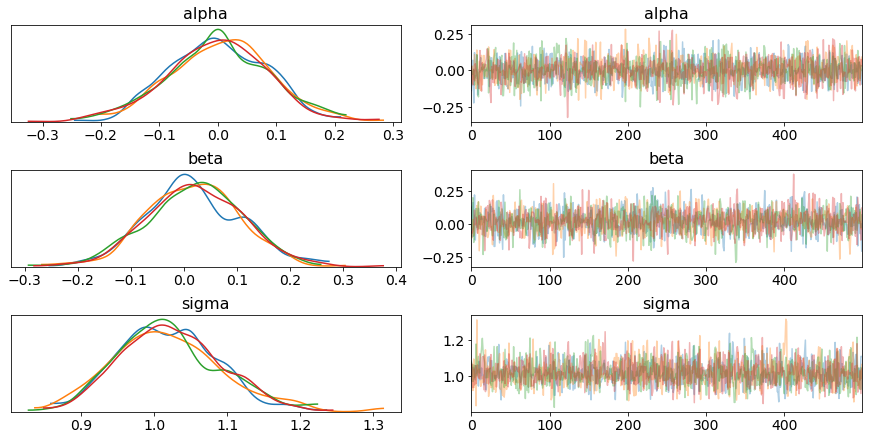

In [10]:
pm.traceplot(posterior_1);

_We can also plot the posterior using `arviz` in a nice way using the functions_ `from_pymc3` _and_ `plot_forest`.

In [11]:
data = az.from_pymc3(trace=posterior_1,
                     prior=prior,
                     posterior_predictive=posterior_pred_1)
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

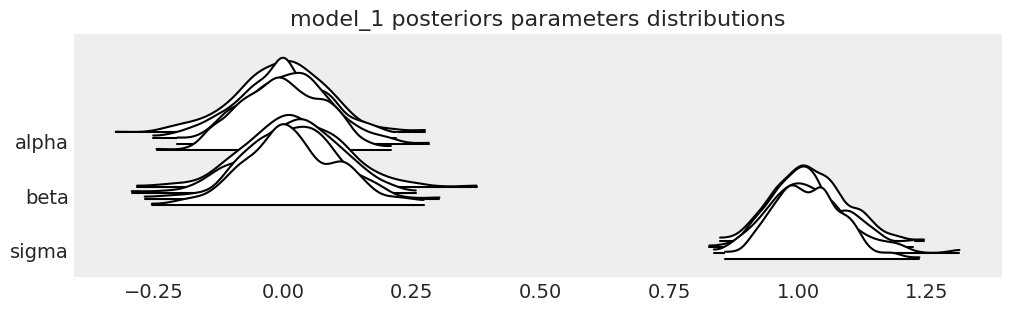

In [12]:
az.style.use('arviz-darkgrid')

fig, axes = az.plot_forest(data,
                           kind='ridgeplot',
                           combined=False,
                           ridgeplot_overlap=2,
                           colors='white',
                           figsize=(10, 3))
axes[0].set_title('model_1 posteriors parameters distributions');

_Let's sample the priors to see if they define a relationship between `area` and `weight` that is logical and possible._

In [13]:
df = pd.DataFrame()
df = df.assign(alpha = pd.Series(prior['alpha']),
               sigma = pd.Series(prior['sigma']),
               beta = pd.Series(prior['beta']))
df.head()

,alpha,sigma,beta
0,0.249445,1.057261,0.156948
1,0.036223,1.663730,0.112277
2,0.221446,1.133799,0.410161
3,-0.122283,0.002218,0.436718
4,-0.030458,1.968364,-0.623742


In [14]:
priors = pd.DataFrame()

for i in range(df.shape[0]):
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i,'beta'] * d['area']
    

In [15]:
aux = pd.concat([d.area, priors], axis=1)
aux_plot = aux.melt(id_vars=['area'],
                  value_vars=list(aux.columns)[1:],
                  var_name='prior',
                  value_name='weight')

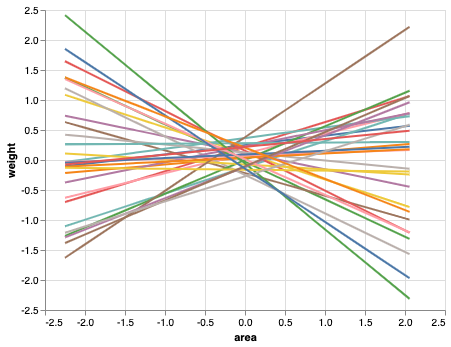

In [16]:
plot = alt.Chart(aux_plot)\
   .mark_line()\
   .encode(
        x=alt.X('area', title='area'),
        y=alt.Y('weight', title='weight'),
        color=alt.Color('prior', legend=None)
          )

plot

_It does seem that the priors are located in the realm of possible values._

## Exercise 2

> Now infer the causal impact of adding food (`avgfood`) to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

To infer the causal influence of `avgfood` on `weight`, we need to close any back-door paths. There are no back-door paths in the DAG. So again, just use a model with a single predictor. If you include `groupsize`, to block the indirect path, then you won't get the total causal influence of food. You'll just get the direct influence. But I asked for the effect of adding food, and that would mean through all forward paths.

In [17]:
with pm.Model() as model_2:
    # Data
    avgfood = pm.Data('avgfood', d['avgfood'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta = pm.Normal('beta', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta * avgfood
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 30)
    posterior_2 = pm.sample()
    posterior_pred_2 = pm.sample_posterior_predictive(posterior_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 2000/2000 [01:17<00:00, 25.83it/s]


In [18]:
az.summary(posterior_2, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.08,0.0,0.0,-0.13,0.14,2385.0,952.0,2393.0,1391.0,1.00
beta,-0.02,0.09,0.0,0.0,-0.16,0.13,2705.0,1113.0,2711.0,1594.0,1.01
sigma,1.02,0.07,0.0,0.0,0.91,1.12,2319.0,2269.0,2396.0,1511.0,1.00


Again nothing. Adding food does not change `weight`. This shouldn't surprise you, if the DAG is correct, because `area` is upstream of `avgfood`.

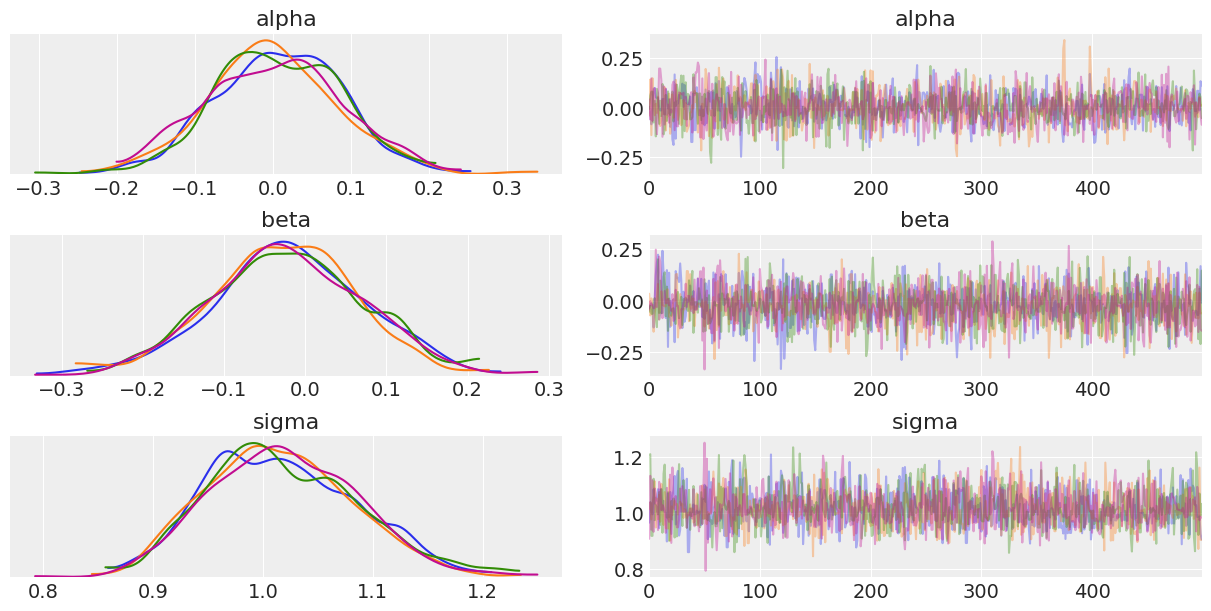

In [19]:
pm.traceplot(posterior_2);

## Exercise 3

> Now infer the causal impact of `groupsize`. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?

In [20]:
with pm.Model() as model_3:
    # Data
    avgfood = pm.Data('avgfood', d['avgfood'].values)
    groupsize = pm.Data('groupsize', d['groupsize'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta = pm.Normal('beta', mu=0, sd=0.5, shape=2) # In the solutions these are called bF and bG, here is just beta with two dimensions
    sigma = pm.Uniform('sigma', lower=0, upper=2)    
    
    # Regression
    mu = alpha + beta[0] * avgfood + beta[1] * groupsize
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 30)
    posterior_3 = pm.sample()
    posterior_pred_3 = pm.sample_posterior_predictive(posterior_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 2000/2000 [01:11<00:00, 27.99it/s]


In [21]:
az.summary(posterior_3, credible_interval=.89).round(2)

,mean,sd,mcse_mean,mcse_sd,hpd_5.5%,hpd_94.5%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.00,0.08,0.0,0.0,-0.13,0.13,1932.0,887.0,1939.0,1372.0,1.01
beta[0],0.48,0.18,0.0,0.0,0.19,0.76,1274.0,1274.0,1281.0,1530.0,1.00
beta[1],-0.57,0.18,0.0,0.0,-0.84,-0.28,1264.0,1264.0,1281.0,1397.0,1.00
sigma,0.97,0.06,0.0,0.0,0.87,1.07,1708.0,1698.0,1719.0,1133.0,1.00


_Very cool! The direct effect of `avgfood` is actually positive! But since it is controlled by the negative effect of `groupsize` the total effect of `avgfood` on `weight` is nothing._

It looks like `groupsize` is negatively associated with `weight`, controlling for `avgfood`. Similarly, `avgfood` is positively associated with `weight`, controlling for `groupsize`. So the causal influence of `groupsize` is to reduce `weight` — less food for each fox. And the direct causal influence of `avgfood` is positive, of course. But the total causal influence of `avgfood` is still nothing, since it causes
larger groups. This is a masking effect, like in the milk energy example. But the causal explanation here is that more foxes move into a territory until the food available to each is no better than the food in a neighboring territory. Every territory ends up equally good/bad on average. This is known in behavioral ecology as an ideal free distribution.

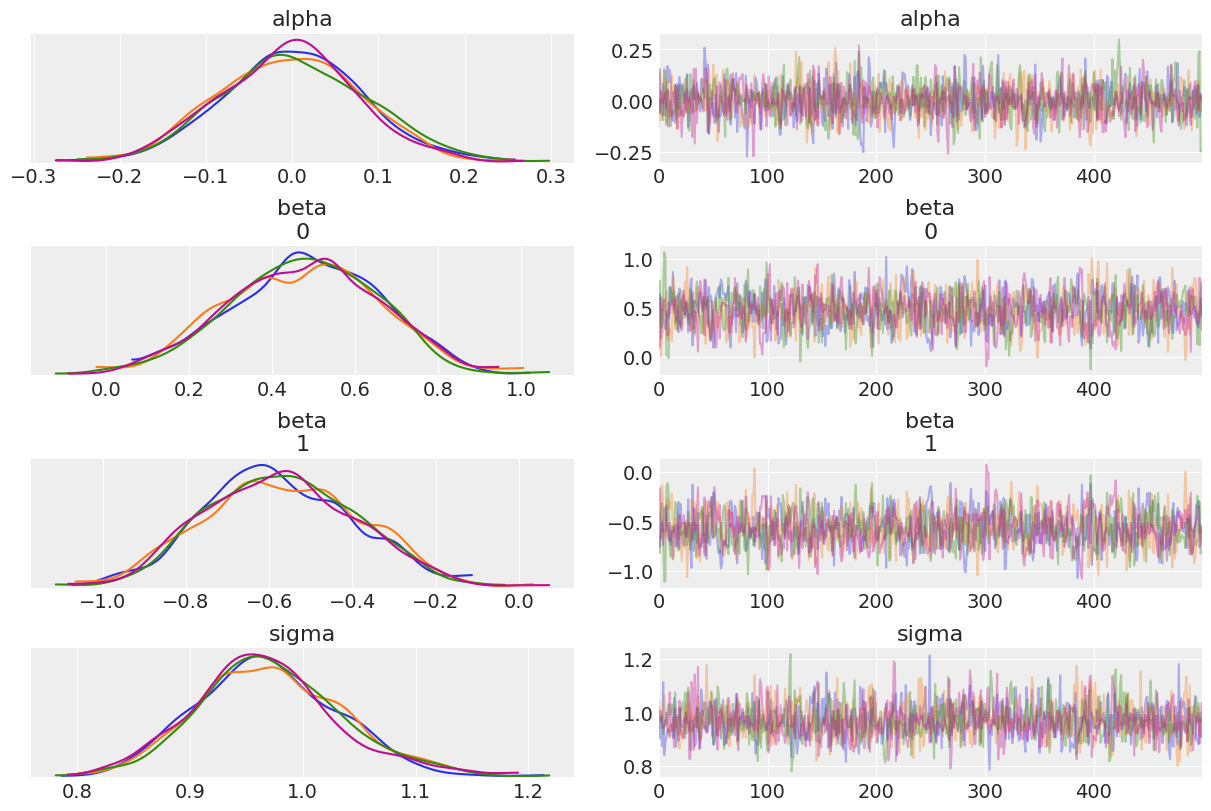

In [22]:
pm.traceplot(posterior_3);

In [23]:
data = az.from_pymc3(trace=posterior_3,
                     prior=prior,
                     posterior_predictive=posterior_pred_3)
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

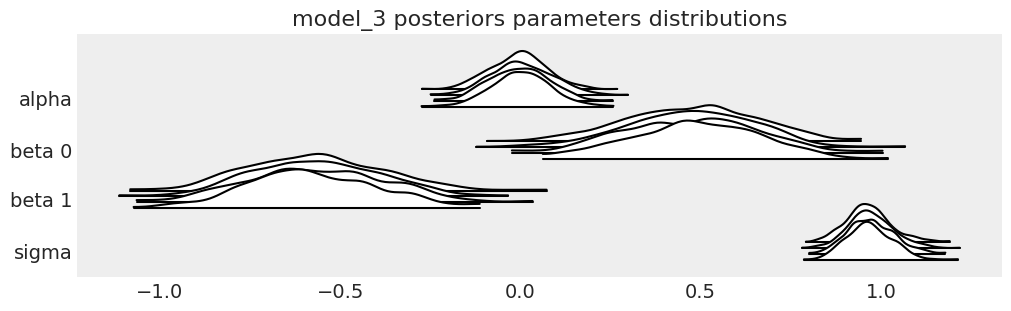

In [24]:
az.style.use('arviz-darkgrid')

fig, axes = az.plot_forest(data,
                           kind='ridgeplot',
                           combined=False,
                           ridgeplot_overlap=1,
                           colors='white',
                           figsize=(10, 3))
axes[0].set_title('model_3 posteriors parameters distributions');